# Classifying Cats and Dogs Images with ResNet-50

* Weights used in this ResNet-50 model are transferred from a training session using ImageNet data;
* Since we have just a few cats and dogs images, transfer learning will help us a lot;
* First, we use the original weights transferred. Later, we train new dense layers for our ResNet-50 retrained model;
* Implementation loosely based on the paper: https://arxiv.org/abs/1409.0575
* Dataset used: https://www.kaggle.com/tongpython/cat-and-dog

In [ ]:
import zipfile
import os

import numpy as np
import seaborn as sns
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Extract training set from 'Cats and Dogs' dataset.
zip_object = zipfile.ZipFile('../data/raw/cats_training.zip')
zip_object.extractall('../data/interim/training_set')
zip_object.close()
zip_object = zipfile.ZipFile('../data/raw/dogs_training.zip')
zip_object.extractall('../data/interim/training_set')
zip_object.close()

# Extract testing set from 'Cats and Dogs' dataset.
zip_object = zipfile.ZipFile('../data/raw/cats_testing.zip')
zip_object.extractall('../data/interim/testing_set')
zip_object.close()
zip_object = zipfile.ZipFile('../data/raw/dogs_testing.zip')
zip_object.extractall('../data/interim/testing_set')
zip_object.close()


---

After extracting the images from the zipped directories using Python's zipfile, we load a ResNet-50 model trained using the [ImageNet](https://www.image-net.org) dataset. With this transferred ResNet-50 we can perform tests using any image having 224x224 resolution.

After loading the image that we want to use, we need to preprocess the image using the same method used in ResNet-50's training. Fortunately, TensorFlow gives us a function to do exactly so.

Lastly, we can use the trained ResNet-50 to predict the class of the preprocessed image. Since it is trained on ImageNet, it is going to return 1000 scores in a list, one for each ImageNet class. We can filter just the top 5 scores and see the name of these 5 first classes to check if the prediction makes sense.

In [ ]:
resnet50_model = keras.applications.ResNet50(weights='imagenet')

102981632/102967424 [==============================] - 1s 0us/step


(1, 224, 224, 3)


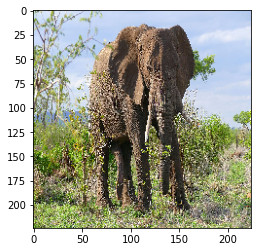

In [ ]:
sample_image = keras.preprocessing.image.load_img(
    '../data/raw/African_Elephant.jpg',
    target_size=(224, 224)
)
plt.imshow(sample_image)

# Transform to numpy array and add a new dimension as axis 0 so that
# the model can work with it as a batch of size 1.
sample_image = np.array(sample_image)
sample_image = np.expand_dims(sample_image, axis=0)
print(sample_image.shape)

In [ ]:
sample_image = keras.applications.resnet50.preprocess_input(sample_image)

# Maximum and minimum pixel values gives us an idea on the
# preprocessing performed in image features.
print("Maximum pixel value in image after ResNet-50 normalization: ",
      sample_image.max())
print("Minimum pixel value in image after ResNet-50 normalization: ",
      sample_image.min())

Maximum pixel value in image after ResNet-50 normalization:  151.061
Minimum pixel value in image after ResNet-50 normalization:  -123.68


In [ ]:
prediction = resnet50_model.predict(sample_image)
print("Prediction: ",
      keras.applications.resnet50.decode_predictions(prediction, top=5))

49152/35363 [=========================================] - 0s 0us/step
Prediction:  [[('n01871265', 'tusker', 0.6575597), ('n02113799', 'standard_poodle', 0.12074281), ('n02504458', 'African_elephant', 0.095717765), ('n02504013', 'Indian_elephant', 0.08039232), ('n02102973', 'Irish_water_spaniel', 0.022263931)]]



---

Since this is a full transferred ResNet-50, its last layer will return 1000 class probabilities, one for each ImageNet class. ImageNet's classes are not the same as our classes (Cat and Dog), even though there may be some cat and dog species classes in there.

Therefore, our next move is to load the ResNet-50 without its top layers. Without the top layers, the transferred base ResNet-50, made of convolutional and regularization layers only, becomes an image feature extractor.

In [ ]:
base_resnet50 = keras.applications.ResNet50(include_top=False, 
                                             weights='imagenet')

base_resnet50.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                          


---

We can plug-in and train some fully connected layers at the top of the convolutional ones from the base ResNet-50 to adapt the model to work with our classes.

Since this loaded ResNet-50 was instantiated using TensorFlow's functional API, we can easily add more layers using the same API.

Note that with the neural network architecture summary from the previous cell, we know that the last layer of the base ResNet-50 outputs 2048 values. We argue that it is reasonable for the next layers to be a global average pooling followed by a fully connected (dense) layer with 1024 neurons, half the dimensionality of the output from the base ResNet-50.

In [ ]:
# Create fully connected layers on top of the transferred
# convolutional layers using TensorFlow's functional API.
top_resnet50 = base_resnet50.output
top_resnet50 = keras.layers.GlobalAveragePooling2D()(top_resnet50)

# 1024 neurons are half the 2048 output dimensionality of the previous
# layer and the last layer from base ResNet-50.
top_resnet50 = keras.layers.Dense(units=1024, activation='relu')(top_resnet50)
top_resnet50 = keras.layers.Dense(units=512, activation='relu')(top_resnet50)
top_resnet50 = keras.layers.Dense(units=256, activation='relu')(top_resnet50)
top_resnet50 = keras.layers.Dense(units=128, activation='relu')(top_resnet50)
top_resnet50 = keras.layers.Dense(units=1, activation='sigmoid')(top_resnet50)

resnet50_model = keras.models.Model(inputs=base_resnet50.input,
                                    outputs=top_resnet50)

resnet50_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           


---

By checking the number of images inside both directories from our dataset, we can define a data-driven batch size. During our training session, it was decided that 200 batches was the best number to train this model.

Given that we are using transfer learning and the fact that this is a simple binary classification dataset, the model is able to converge in less than 10 epochs. Learning rate decay and early stopping were set to help the model train and stop ideally in the last training iterations.

In [ ]:
# Count number of training images for both classes to calculate a
# data-driven training batch size.
num_samples = (len(os.listdir('../data/interim/training_set/cats')) +
               len(os.listdir('../data/interim/training_set/dogs')))

# We use 200 batches.
batch_size = num_samples // 200

# Use ResNet-50's preprocessing function in the image loader.
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input,
    validation_split=0.15
)

# Set seed to make results more reproducible and comparable.
train_flow = train_datagen.flow_from_directory(
    '../data/interim/training_set',
    batch_size=batch_size,
    target_size=(224, 224),
    class_mode='binary',
    subset='training',
    seed=42
)

validation_flow = train_datagen.flow_from_directory(
    '../data/interim/training_set',
    batch_size=batch_size,
    target_size=(224, 224),
    class_mode='binary',
    subset='validation',
    seed=42
)

Found 6805 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


In [ ]:
# Set all layers until layer 175 (last layer from base ResNet-50) to
# not trainable so that their weights remain the same.
for layer in resnet50_model.layers[:175]:
    layer.trainable = False

# Patience for early stopping and learning rate decay were tuned during
# our training session.
early_stopping = keras.callbacks.EarlyStopping(patience=5,
                                               restore_best_weights=True)
learning_rate_decay = keras.callbacks.ReduceLROnPlateau(patience=3)

resnet50_model.compile(optimizer='Adam',
                       loss='binary_crossentropy',
                       metrics='accuracy')

# 100 epochs are enough for this dataset. Early stopping was always
# triggered before 100 epochs.
epochs_info = resnet50_model.fit(train_flow,
                                 epochs = 100,
                                 callbacks=[early_stopping,
                                            learning_rate_decay],
                                 validation_data=validation_flow)

Epoch 1/100
171/171 [==============================] - 43s 222ms/step - loss: 0.0934 - accuracy: 0.9672 - val_loss: 0.0337 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 2/100
171/171 [==============================] - 36s 210ms/step - loss: 0.0321 - accuracy: 0.9899 - val_loss: 0.0378 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 3/100
171/171 [==============================] - 37s 218ms/step - loss: 0.0224 - accuracy: 0.9913 - val_loss: 0.0599 - val_accuracy: 0.9858 - lr: 0.0010
Epoch 4/100
171/171 [==============================] - 37s 213ms/step - loss: 0.0221 - accuracy: 0.9919 - val_loss: 0.0329 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 5/100
171/171 [==============================] - 37s 214ms/step - loss: 0.0123 - accuracy: 0.9954 - val_loss: 0.0420 - val_accuracy: 0.9842 - lr: 0.0010
Epoch 6/100
171/171 [==============================] - 36s 213ms/step - loss: 0.0090 - accuracy: 0.9978 - val_loss: 0.0806 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 7/100
171/171 [=========================

If we observe the loss and accuracy progression during training in the plots below, we can see that the model already starts with very good values. This behavior is expected as we are using transfer learning. Our transferred base ResNet-50 already has good weights to classify cats and dogs images.

The evolution in both metrics is very small, especially considering the validation set. The 9 iterations training our model work more as an adaptation phase to make a very good model work in our binary classification setting.

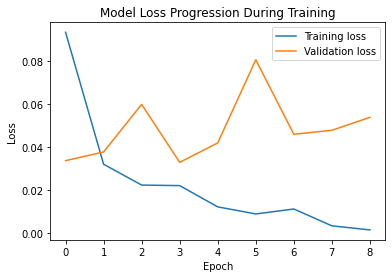

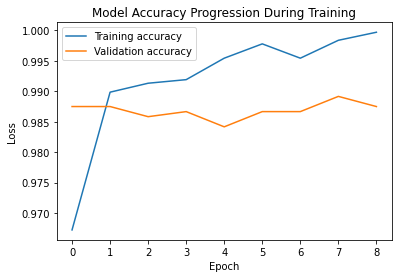

In [ ]:
plt.plot(epochs_info.history['loss'])
plt.plot(epochs_info.history['val_loss'])
plt.title("Model Loss Progression During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training loss", "Validation loss"])

plt.figure()
plt.plot(epochs_info.history['accuracy'])
plt.plot(epochs_info.history['val_accuracy'])
plt.title("Model Accuracy Progression During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training accuracy", "Validation accuracy"])
plt.show()

We have a separate testing set to measure our model performance on data not used for training nor validation (fine-tuning). We create a new image loader for the testing set and evaluate it using TensorFlow's built-in `evaluate` function for our retrained ResNet-50 model. The model achieves a very good performance, hitting almost 99% accuracy.

We also create a confusion matrix using our model's binary predictions. The matrix reassures our conclusion that the model is performing neatly. There are very few false positives [0, 1] and false negatives [1, 0].

In [ ]:
# Use ResNet-50's preprocessing function in the image loader.
test_gen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input
)

# Set seed to make results more reproducible and comparable.
test_flow = test_gen.flow_from_directory('../data/interim/testing_set',
                                         batch_size=batch_size,
                                         target_size=(224, 224),
                                         class_mode='binary',
                                         shuffle=False,
                                         seed=42)

Found 2023 images belonging to 2 classes.


In [ ]:
resnet50_model.evaluate(test_flow)

51/51 [==============================] - 10s 184ms/step - loss: 0.0339 - accuracy: 0.9881


[0.03387245535850525, 0.9881364107131958]

In [ ]:
# We can separate the classes by evaluating if the output of the
# sigmoid activation function is greater than 0.5.
y_pred = resnet50_model.predict(test_flow)
y_pred_classes = (y_pred > 0.5)

cm = confusion_matrix(test_flow.labels, y_pred_classes)
print("Model prediction confusion matrix:")
print(cm)

Model prediction confusion matrix:
[[ 999   12]
 [  12 1000]]


In [ ]:
target_names = ['Class 1: cat', 'Class 2: dog']

print(classification_report(test_flow.labels, y_pred_classes,
                            target_names=target_names))

              precision    recall  f1-score   support

Class 1: cat       0.99      0.99      0.99      1011
Class 2: dog       0.99      0.99      0.99      1012

    accuracy                           0.99      2023
   macro avg       0.99      0.99      0.99      2023
weighted avg       0.99      0.99      0.99      2023



Scikit-learn's classification report agrees with our previous results: our model achieves very good precision and recall results for both classes.

Finally, to visualize our model classifications, we create a new test image loader with shuffle turned on. We get 25 random images from both classes (Cat and Dog) and plot them in a grid along with their labels predicted by our retrained ResNet-50.

In the random batch obtained for this run, we can see one of the mistakes comitted by the model on image [3, 1]. A cat is labeled as a dog. It is an understandable mistake as there is a balloon in the image creating lots of noise.

Found 2023 images belonging to 2 classes.


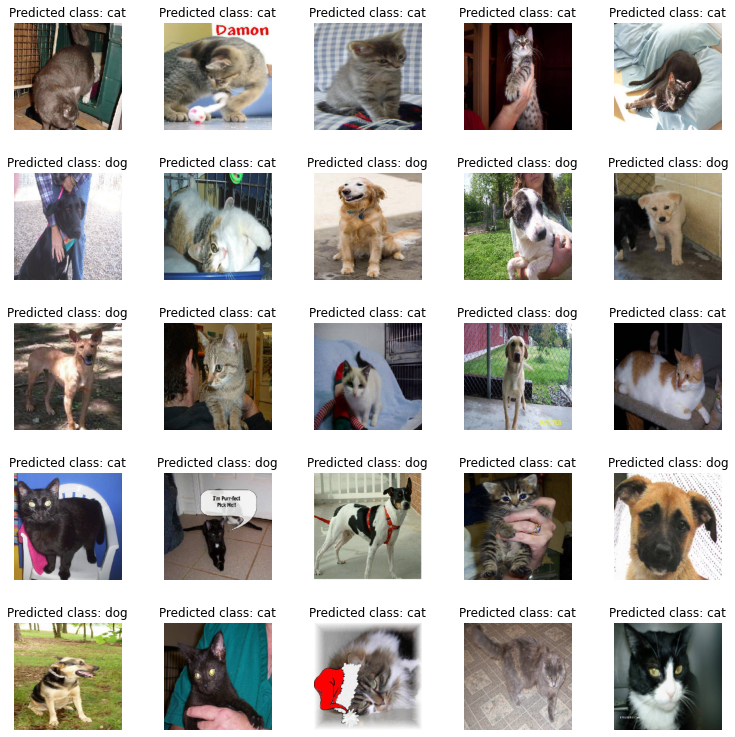

In [ ]:
# Create a test loader to visualize the model's predictions.
test_gen = keras.preprocessing.image.ImageDataGenerator()
test_flow = test_gen.flow_from_directory('../data/interim/testing_set',
                                         batch_size=batch_size,
                                         target_size=(224, 224),
                                         class_mode='binary',
                                         shuffle=True,
                                         seed=42)

# Get the next batch from the image loader and preprocess it.
sample = test_flow.next()
sample = sample[0].astype(np.int32)
sample_preprocessed = keras.applications.resnet50.preprocess_input(sample)

y_pred = resnet50_model.predict(sample_preprocessed)
y_pred_classes = (y_pred > 0.5)

grid_height = 5
grid_width = 5

fig, axes = plt.subplots(grid_height, grid_width, figsize=(13, 13))
axes = axes.ravel()

for i in range(grid_height * grid_width):
    axes[i].imshow(sample[i])
    axes[i].set_title(
        label="Predicted class: cat"
        if y_pred_classes[i] == False
        else "\nPredicted class: dog"
    )
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)